# 기온 예측 문제

In [1]:
import os

data_dir = "datasets/jena_climate/"
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

In [2]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [4]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

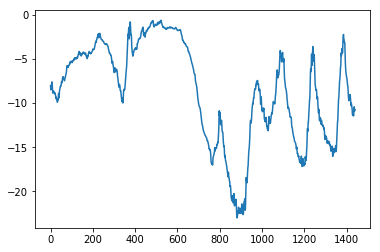

In [5]:
plt.plot(range(1440), temp[:1440])

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [7]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size =batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle = True,
                      step = step,
                      batch_size =batch_size)
val_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=200001,
                      max_index=300000,
                      step = step,
                      batch_size =batch_size)
test_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=300001,
                      max_index=None,
                      step = step,
                      batch_size =batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [9]:
def evaluate_native_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_native_method()

0.2897359729905486


In [10]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

## 기본적인 머신 러닝

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [12]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 14s 29ms/step - loss: 1.4326 - val_loss: 0.6737
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.4680 - val_loss: 0.4874
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2993 - val_loss: 0.3444
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2668 - val_loss: 0.3194
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2520 - val_loss: 0.3059
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2434 - val_loss: 0.3213
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2359 - val_loss: 0.3233
Epoch 8/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2293 - val_loss: 0.3337
Epoch 9/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2258 - val_loss: 0.3277
Epoch 10/20
500/500 [==============================] - 11s 22ms/step - loss: 0.219

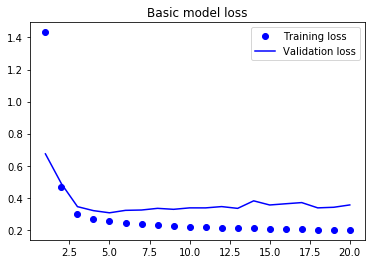

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Basic model loss')
plt.legend()

plt.show()

## 1  GRU

In [16]:
model = Sequential()
model.add(layers.GRU(32, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 164s 328ms/step - loss: 0.3020 - val_loss: 0.2684
Epoch 2/20
500/500 [==============================] - 175s 351ms/step - loss: 0.2862 - val_loss: 0.2672
Epoch 3/20
500/500 [==============================] - 166s 333ms/step - loss: 0.2812 - val_loss: 0.2653
Epoch 4/20
500/500 [==============================] - 165s 330ms/step - loss: 0.2752 - val_loss: 0.2643
Epoch 5/20
500/500 [==============================] - 161s 322ms/step - loss: 0.2706 - val_loss: 0.2700
Epoch 6/20
500/500 [==============================] - 174s 347ms/step - loss: 0.2661 - val_loss: 0.2693
Epoch 7/20
500/500 [==============================] - 167s 333ms/step - loss: 0.2619 - val_loss: 0.2708
Epoch 8/20
500/500 [==============================] - 160s 320ms/step - loss: 0.2556 - val_loss: 0.2732
Epoch 9/20
500/500 [==============================] - 162s 323ms/step - loss: 0.2503 - val_loss: 0.2745
Epoch 10/20
500/500 [==============================] - 159s 319m

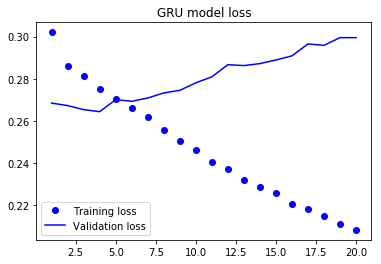

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GRU model loss')
plt.legend()

plt.show()

## Use Dropout

In [ ]:
model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 204s 408ms/step - loss: 0.3455 - val_loss: 0.2750
Epoch 2/40
500/500 [==============================] - 191s 383ms/step - loss: 0.3143 - val_loss: 0.2726
Epoch 3/40
500/500 [==============================] - 194s 388ms/step - loss: 0.3077 - val_loss: 0.2698
Epoch 4/40
500/500 [==============================] - 190s 380ms/step - loss: 0.3051 - val_loss: 0.2701
Epoch 5/40
500/500 [==============================] - 193s 385ms/step - loss: 0.3007 - val_loss: 0.2703
Epoch 6/40
500/500 [==============================] - 193s 386ms/step - loss: 0.2970 - val_loss: 0.2681
Epoch 7/40
500/500 [==============================] - 192s 384ms/step - loss: 0.2947 - val_loss: 0.2704
Epoch 8/40
500/500 [==============================] - 202s 404ms/step - loss: 0.2936 - val_loss: 0.2662
Epoch 9/40
500/500 [==============================] - 177s 354ms/step - loss: 0.2931 - val_loss: 0.2675
Epoch 10/40
500/500 [==============================] - 182s 364m

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GRU + Dropout model loss')
plt.legend()

plt.show()

## GRU + Dropout + Add layer model

In [ ]:
model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layer.Dense(1))

model.complie(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GRU + Dropout + Add layer model loss')
plt.legend()

plt.show()

## bidirectional LSTM

In [ ]:
model = Sequential()
model.add(layers.Bidirenctional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer='RMSprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('bidirectional GRU model loss')
plt.legend()

plt.show()